## 2. Introduction to Spatial Metrics

This section will focus on methods for pairwise spatial analysis - comparing whether two populations are spatially correlated. There are a large number of spatial metrics which deal with this topic, many of which we have tutorials for (https://docs.muspan.co.uk/latest/tutorials.html). Here, we'll focus on the cross-pair correlation function (xPCF), and later Moran's I / Getis-Ord.


In this section we will:
- Introduce the cross-pair correlation function
- Understand how changing the parameters of the cross-PCF affects the results
- Use the topographical correlation map to visualise hotspots of correlation within a domain
- Explore the effect of changing the domain boundary on the cross-PCF, and understand the importance of accurate domain boundaries
- Explore alternative methods for describing pairwise spatial interactions between populations

### The cross-pair correlation function: exploring spatial colocalisation

Load in the `Synthetic-Points-Architecture` dataset (https://docs.muspan.co.uk/latest/muspan.datasets.html#datasets). We'll start by visualising the cells.

MuSpAn domain loaded successfully. Domain summary:
Domain name: Architecture
Number of objects: 5991
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []


(<Figure size 1000x800 with 2 Axes>, <Axes: >)

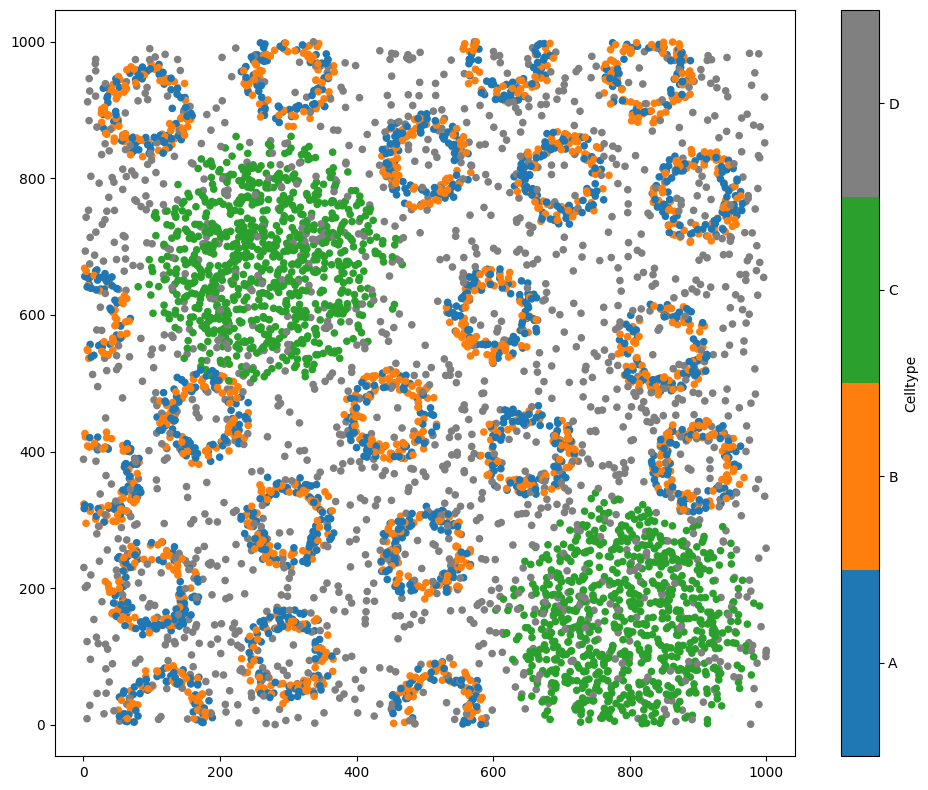

In [1]:
import muspan as ms

domain = ms.datasets.load_example_domain('Synthetic-Points-Architecture')

ms.visualise.visualise(domain, 'Celltype')

We'll analyse this region because there are some very distinctive spatial behaviours in it. In particular, some of the populations are spatially colocalised, some are excluded from one another, and some are spatially independent. Let's try and use the pair correlation function to find out which are which.

First, let's take a look at MuSpAn's cross pair correlation function function. Remember that we can always use the [MuSpAn docs](https://docs.muspan.co.uk/latest/generated/muspan.spatial_statistics.cross_pair_correlation_function.html#muspan.spatial_statistics.cross_pair_correlation_function) to check what arguments we can change in the function. For now, let's leave the default arguments as they are, and just specify two cell populations to compare.

(array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 array([4.57861949, 3.50117673, 2.46628041, 1.58916269, 1.2509999 ,
        1.11657277, 1.03252638, 1.10767773, 1.3240956 , 1.46645039,
        1.40737807]))

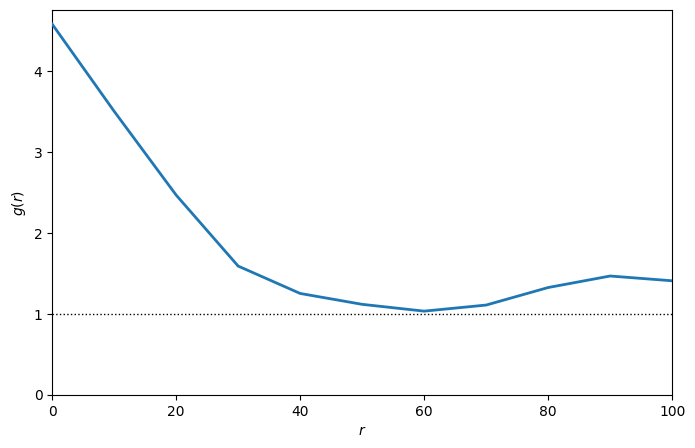

In [2]:
population_A = ('Celltype','A')
population_B = ('Celltype','B')

ms.spatial_statistics.cross_pair_correlation_function(domain, population_A, population_B, visualise_output=True)

The only optional argument we changed here was `visualise_output=True`, which is a handy option available in the majority of MuSpAn's analysis functions to easily see what the function output looks like. In this case, we can see that the default parameters have given us a nice looking curve: it is much bigger than 1 for small values of $r$, suggesting positive correlation between cell types A and B at short length scales, before dipping down.

Let's think about the interpretation of the cross-PCF. In particular, we'll think about the three key parameters `max_R=100`, `annulus_step=10`, and `annulus_width=10`. Conceptually, we interpret the cross-PCF by imagining an annulus of inner radius $r$ centred on a cell of type $A$. This annulus has width `annulus_width`, and the function that we consider here if calculated at specific values of $r$ (one every `annulus_step` - so here at 0, 10, 20, ..., 100).

We'll start by playing with those parameters. We'll also collect the output into two variables, $r$ and $g$, that we could use to plot the function (we won't for now, they're just here so that the arrays don't get printed out).

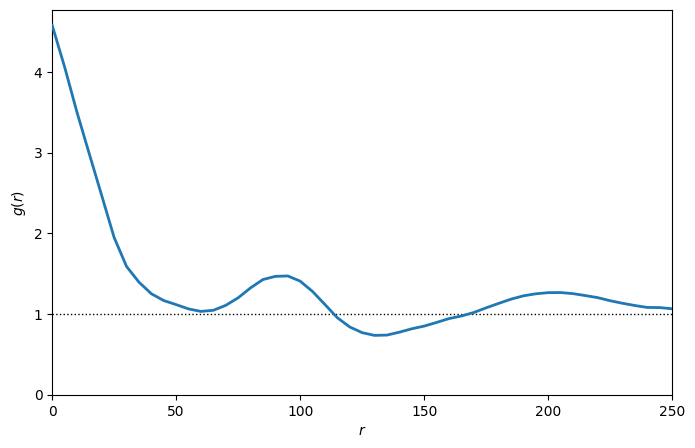

In [3]:
r, g = ms.spatial_statistics.cross_pair_correlation_function(domain, population_A, population_B, 
                                                      annulus_step=5,
                                                      annulus_width=10,
                                                      max_R=250,
                                                      visualise_output=True)

Using a smaller annulus step gives a smoother curve, but notice that it took longer for the function to run this time. This is a common feature of spatial analysis; we have to make a trade off between computational complexity and the level of detail that we want to consider.

Plotting this curve shows some interesting bumps and dips. We have dips (local minima) around $r \approx 60, 125$ and peaks (local maxima) at $r \approx 100, 200$. How might you interpret these bumps?

Let's plot the cross-PCF for each possible combination of celltypes in this example, [using the code from the cross-PCF tutorial](https://docs.muspan.co.uk/latest/_collections/spatial_analysis_methods/Spatial%20stats%20-%201%20-%20pcf.html).

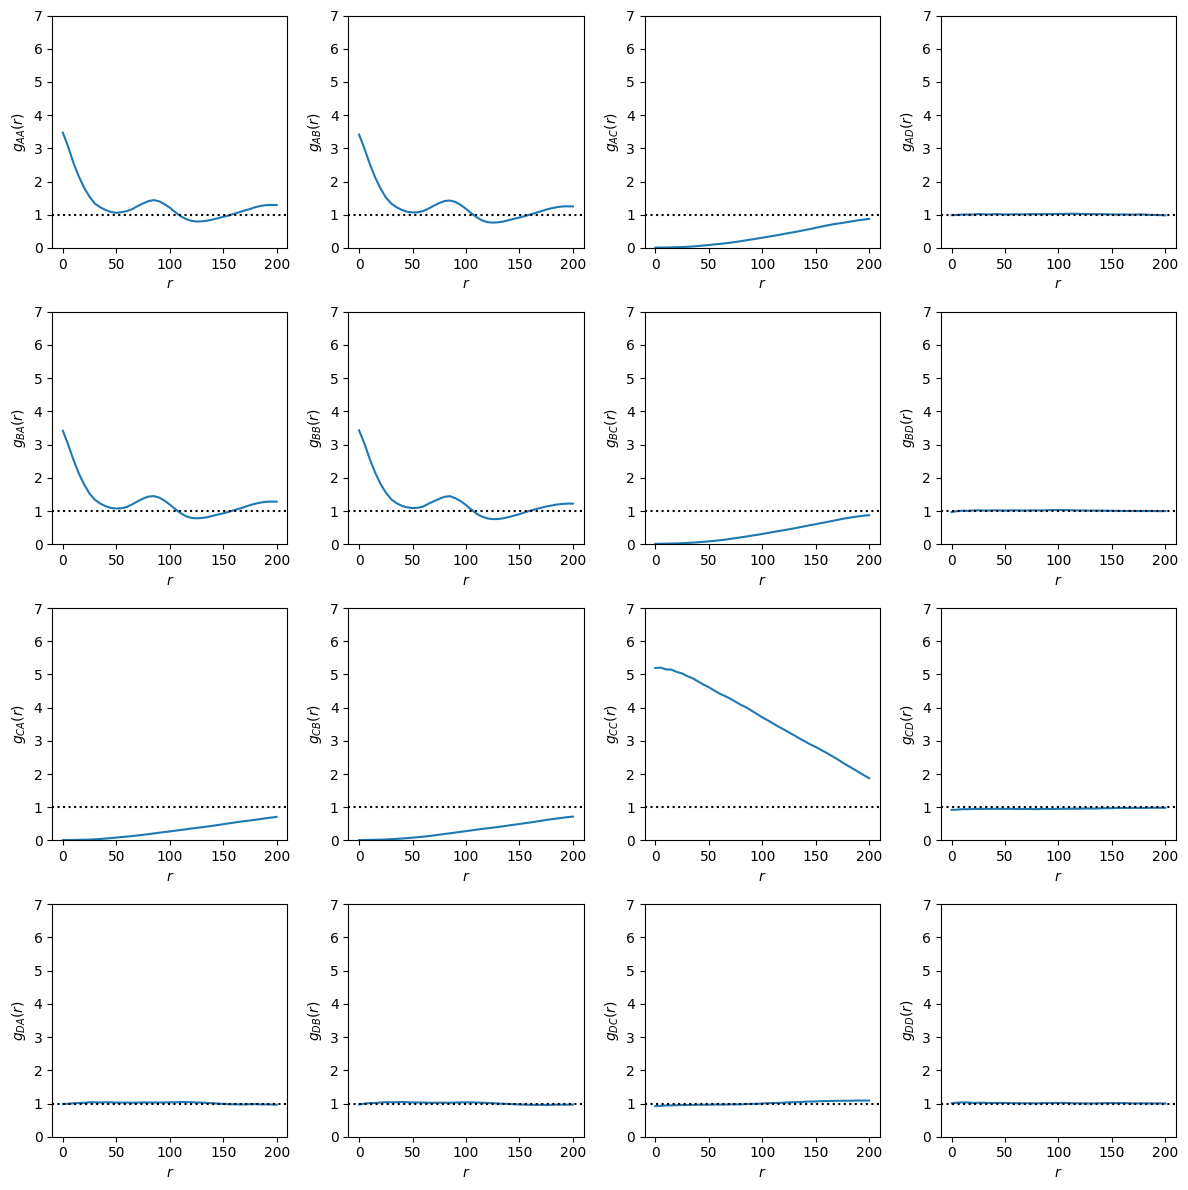

In [4]:
import matplotlib.pyplot as plt
# Define the cell types to be analyzed
celltypes = ['A', 'B', 'C', 'D']

# Create a 4x4 subplot for visualizing the cross-PCF for each combination of cell types
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Loop through each combination of cell types
for i in range(4):
    for j in range(4):
        # Calculate the cross-PCF for the current combination of cell types
        r, PCF = ms.spatial_statistics.cross_pair_correlation_function(
            domain,
            ('Celltype', celltypes[i]),
            ('Celltype', celltypes[j]),
            max_R=200,
            annulus_step=5,
            annulus_width=25
        )

        # Select the current subplot
        ax = axes[i, j]

        # Plot the cross-PCF
        ax.plot(r, PCF)

        # Add a horizontal line at y=1 to indicate the CSR baseline
        ax.axhline(1, color='k', linestyle=':')

        # Set the y-axis limit
        ax.set_ylim([0, 7])

        # Label the y-axis with the cross-PCF notation
        ax.set_ylabel(f'$g_{{{celltypes[i]}{celltypes[j]}}}(r)$')

        # Label the x-axis with the distance r
        ax.set_xlabel('$r$')

# Adjust the layout to prevent overlap
plt.tight_layout()

Which cell types are colocalised? Which are not?

In Figure 4 of https://doi.org/10.1038/s41467-023-42421-0, a similar grid of cross-PCF values is used to get a bird's eye perspective on which cell types are spatially correlated across regions of interest in covid lung tissue. There, the authors condense the full cross-PCFs into a single value, the measurement at $r=20$. Can you see the advantages (and disadvantages) of this choice? We'll explore this further later today.

### Identifying hotspots

If we've used pair correlation functions to identify that there is spatial correlation present between two cell types in a domain, a natural question to follow on with is: <i>where</i> in the domain is this corelation occurring? MuSpAn provides several methods to answer this question. Let's start by considering the [topographical correlation map](https://doi.org/10.1017/S2633903X24000011), a local indicator of spatial association that shows where in the domain cells of type B are positively, or negatively, associated with cells of type A. Let's take a look at this ([MuSpAn docs](https://docs.muspan.co.uk/latest/generated/muspan.spatial_statistics.topographical_correlation_map.html)).

array([[2.74384407, 3.70979324, 4.82413495, ..., 0.        , 0.        ,
        0.        ],
       [3.19806406, 4.34417876, 5.67550698, ..., 0.        , 0.        ,
        0.        ],
       [3.64553046, 4.97074805, 6.51919391, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.03162475, 4.97743159, 5.97452659, ..., 1.04578416, 0.64606049,
        0.36926879],
       [3.1893142 , 3.94722192, 4.7478325 , ..., 0.93327128, 0.57538827,
        0.32679369],
       [2.44184824, 3.02966734, 3.65182173, ..., 0.81499671, 0.50255312,
        0.28443602]])

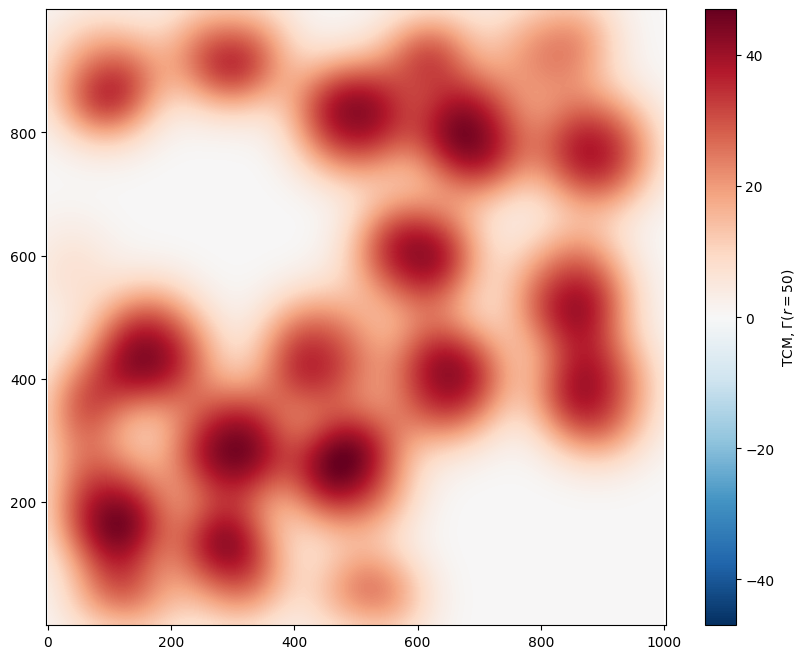

In [5]:
ms.spatial_statistics.topographical_correlation_map(domain, population_A, population_B, visualise_output=True)

The TCM works by calculating the local contribution to the PCF that each individual cell of type A makes, by considering the cumulative contribution of all annuli up to a radius $r$ around that cell <sub>(or more accurately, a normalised form the contribution of that cell to Ripley's K function)</sub>. The hotspots in this plot show us where cells of type B are strongly associated around cells of type A.

For another example, let's plot the association between cells of type D and cells of type A.

array([[-0.03550913,  0.35103809,  0.83600595, ..., -6.94536623,
        -6.22471296, -5.44938314],
       [-0.111257  ,  0.32942861,  0.89443204, ..., -8.34721412,
        -7.48936411, -6.56006606],
       [-0.23679326,  0.25792801,  0.90732137, ..., -9.84924516,
        -8.84827579, -7.75592018],
       ...,
       [ 1.73036741,  2.23881941,  2.80499395, ..., -4.84924027,
        -4.8898893 , -4.66055205],
       [ 1.32915244,  1.73574248,  2.19089052, ..., -4.2687297 ,
        -4.29650705, -4.08898719],
       [ 0.98139188,  1.29595814,  1.65037494, ..., -3.68217708,
        -3.69671604, -3.51154138]])

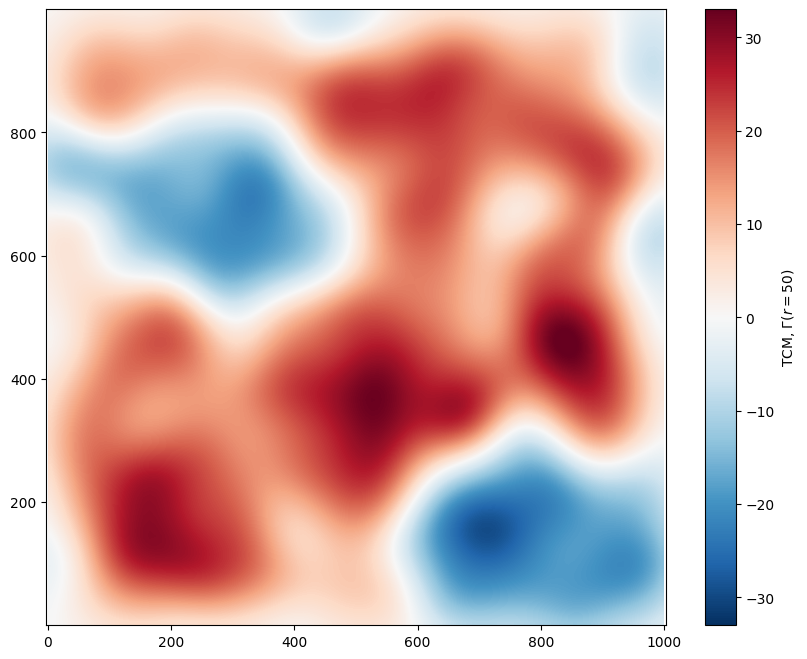

In [6]:
ms.spatial_statistics.topographical_correlation_map(domain, ('Celltype','D'), ('Celltype','A'), visualise_output=True)

This TCM seems to show areas of strong positive, and negative, correlation between the two cell types. Let's plot the locations of cells of type A and D on top of the TCM.

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

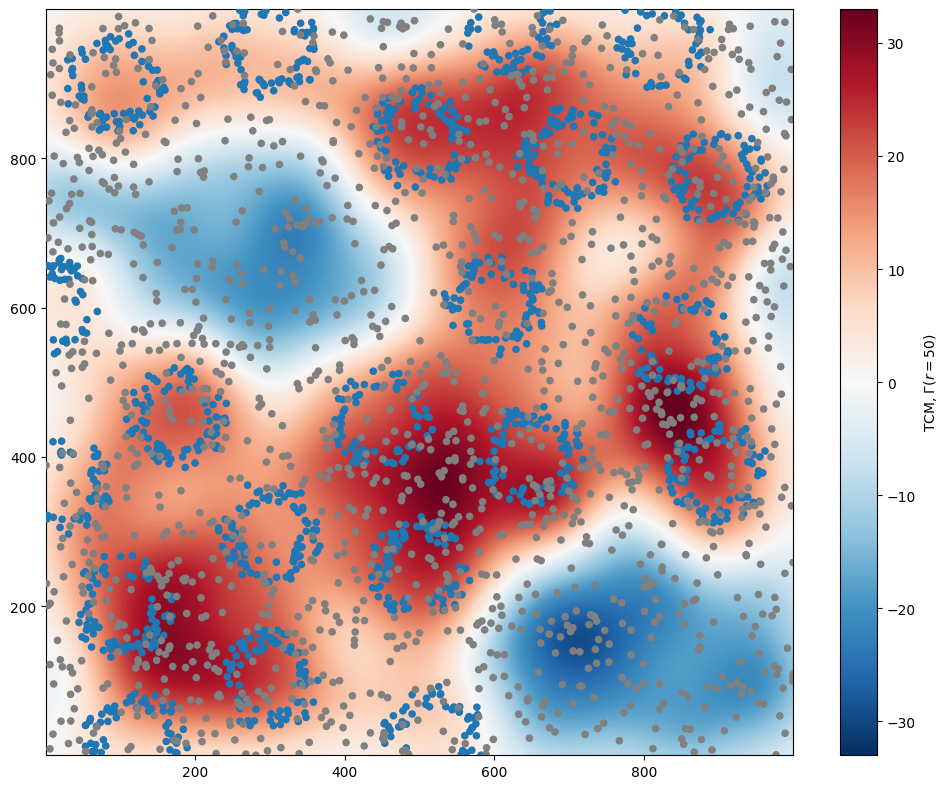

In [7]:
ms.spatial_statistics.topographical_correlation_map(domain, ('Celltype','D'), ('Celltype','A'), visualise_output=True)
ms.visualise.visualise(domain,'Celltype',objects_to_plot=('Celltype','A'),ax=plt.gca(),add_cbar=False)
ms.visualise.visualise(domain,'Celltype',objects_to_plot=('Celltype','D'),ax=plt.gca(),add_cbar=False)

Compare this to the plot of $g_{DA}$ above. What do you see? Do you think there is a real spatial association between cells of types D and A?

### Identifying hotspots: Getis-Ord*

Let's load in an example Visium domain, and visualise one of the Topics included:

MuSpAn domain loaded successfully. Domain summary:
Domain name: Visium-Colon-Adenocarcinoma
Number of objects: 6487
Collections: ['Spots']
Labels: ['Barcode', 'Spot cluster', 'Spot diameter', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16'] 
Networks: [] 
Distance matrices: []


(<Figure size 1000x800 with 2 Axes>, <Axes: >)

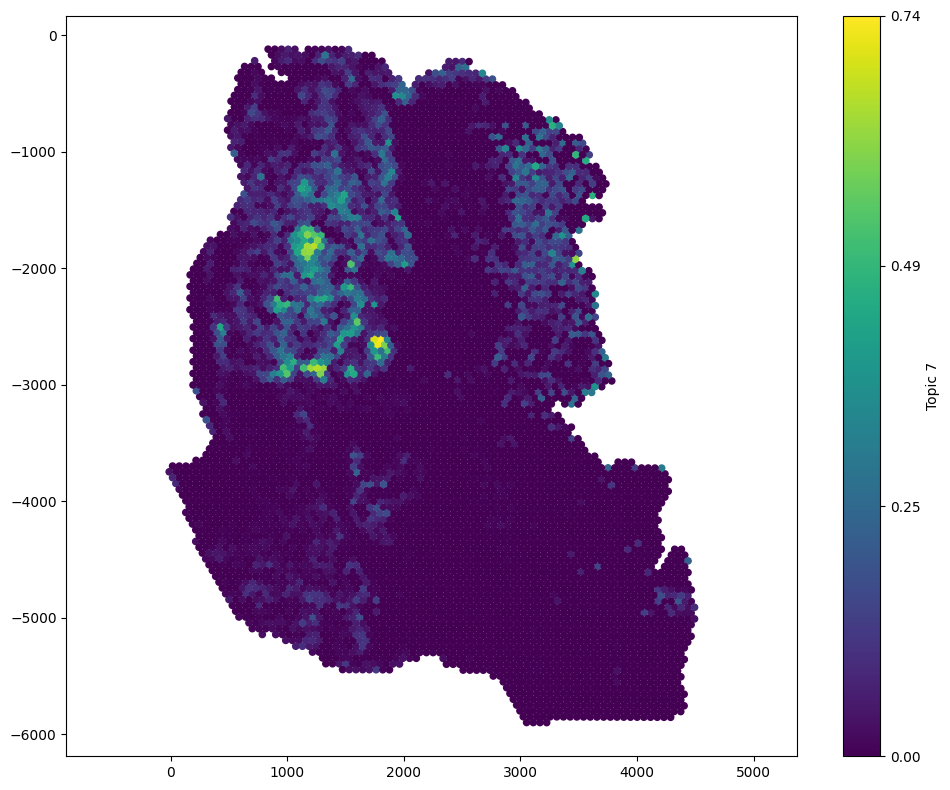

In [8]:
domain = ms.datasets.load_example_domain('Visium-Colon-Adenocarcinoma')
ms.visualise.visualise(domain, 'Topic 7')

Try calculating the Getis-Ord* on this data to identify hot and cold spots. Notice that the code below uses ```network_kwargs``` to specify some key arguments - we'll explore networks further tomorrow. For now, the important thing is that this network defines the connectivity between neighbouring spots. If two spots are within 0 and 60 microns of one another, they'll be connected in the calculation of the Getis-Ord* statistic.

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

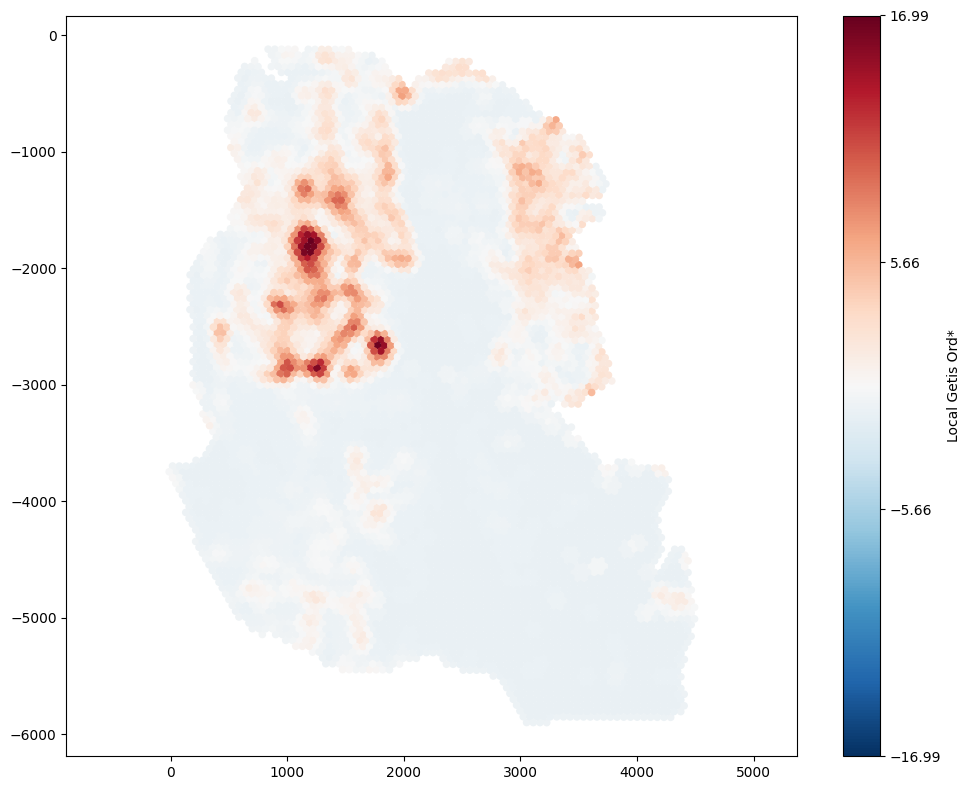

In [9]:
local_getis_ord_zscore, local_getis_ord_pvals, object_indices = ms.spatial_statistics.getis_ord(
    domain,
    population=None,
    label_name='Topic 7',
    alpha=0.05,
    network_kwargs={'network_type': 'Proximity', 'min_edge_distance': 0, 'max_edge_distance': 60},
    add_local_value_as_label=True,
    local_getis_label_name='Local Getis Ord*'
)

ms.visualise.visualise(domain, "Local Getis Ord*")

What happens if you change the values of ``` 'max_edge_distance'``` and ```'min_edge_distance'```? Try making ```max_edge_distance``` large enough so that Visium spots which are not immediately adjacent to one another are connected. What happens if you also change ```min_edge_distance``` to be greater than 0?

Now try calculating the same things, but with the local Moran's I. How does it differ from Getis-Ord*? Can you explain why?

### Quadrat correlation

We can take an ecological approach to identifying spatial correlations using the Quadtrat Correlation Matrix (QCM). 

The QCM divides your study area into smaller regions, called quadrats (or sometimes hexagons, depending on the method). Then it calculates how often different features (like labels A and B) appear together within these regions compared to what you’d expect if everything were scattered randomly (complete spatial randomness). If they show up together more than expected, it might mean there’s some kind of relationship or spatial clustering going on.

For more details on the QCM, see our tutorial and documentation at: https://docs.muspan.co.uk/latest/_collections/region_based_analysis/quadrat_correlation.html

The main parameter we can control here is the size of the lattice we want to check for spatial correlations within (how big are the grid shapes), this should correspond to the length scale we are interested in. In the cellular context, if we're looking for very local interactions, we might set each side of our grid shape to be 50µm. In contrast, if we're thinking about interactions that occour at long ranges (paracrine signalling etc), then we might set this size to 150µm. But it really depends on the biology you're looking for.

Let's show this in action. We'll load in a synthetic datasets and run the QCM using `ms.region_based.quadrat_correlation_matrix()`:



MuSpAn domain loaded successfully. Domain summary:
Domain name: Architecture
Number of objects: 5991
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []


(<Figure size 1000x800 with 2 Axes>, <Axes: >)

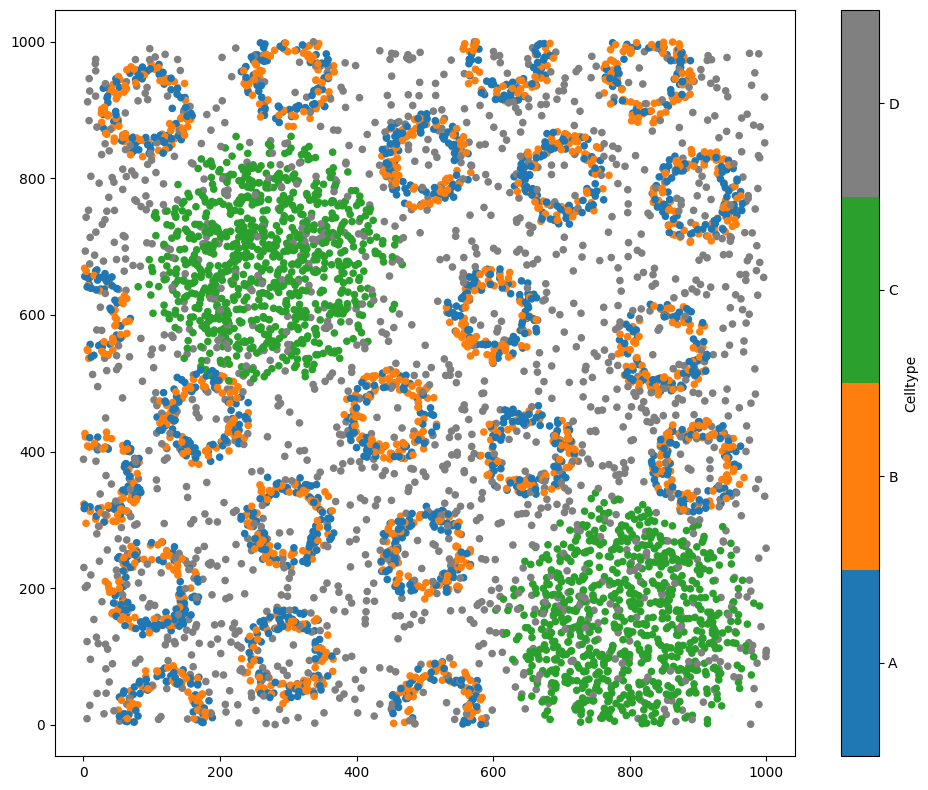

In [10]:
example_domain = ms.datasets.load_example_domain('Synthetic-Points-Architecture')
ms.visualise.visualise(example_domain, 'Celltype')

The lattice in used to compute this method is using either 'generate_hexgrid' or 'generate_quadrats', so to control the size of these grids, we pass the parameters to the `region_kwargs` parameter in the `quadrat_correlation_matrix`. Let's do this for 150µm and visualise the output.

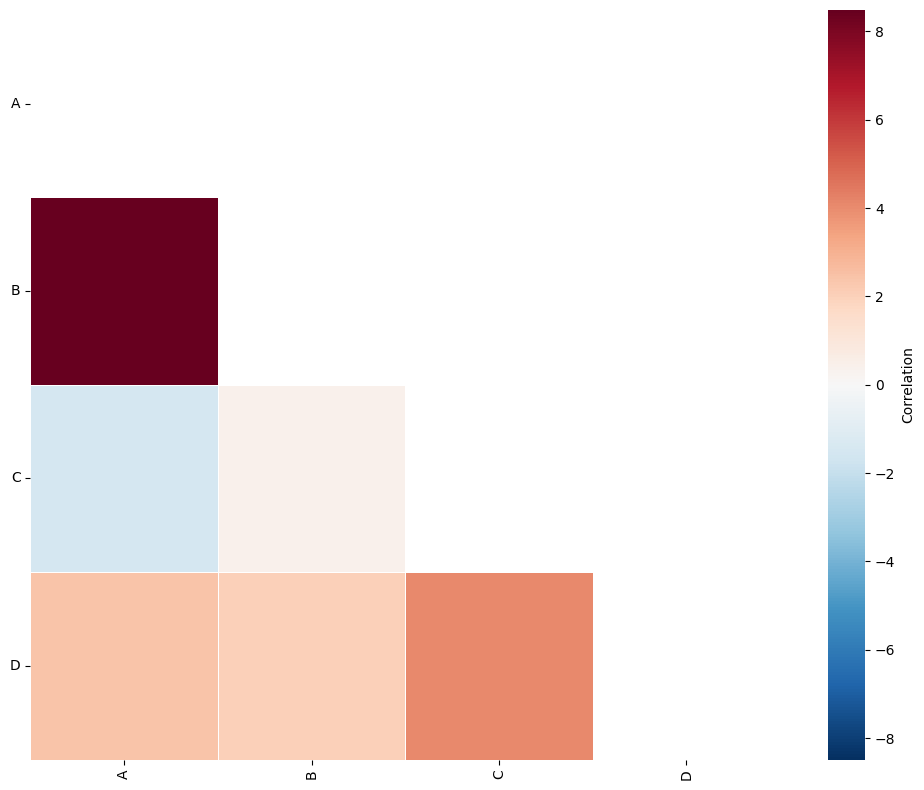

In [12]:
SES,A,labels_categories = ms.region_based.quadrat_correlation_matrix(example_domain,
                                                                     label_name='Celltype',
                                                                     region_method='quadrats',
                                                                     region_kwargs=dict(side_length=150),
                                                                     visualise_output=True)

Let's do this again but with squares of side length 50µm 

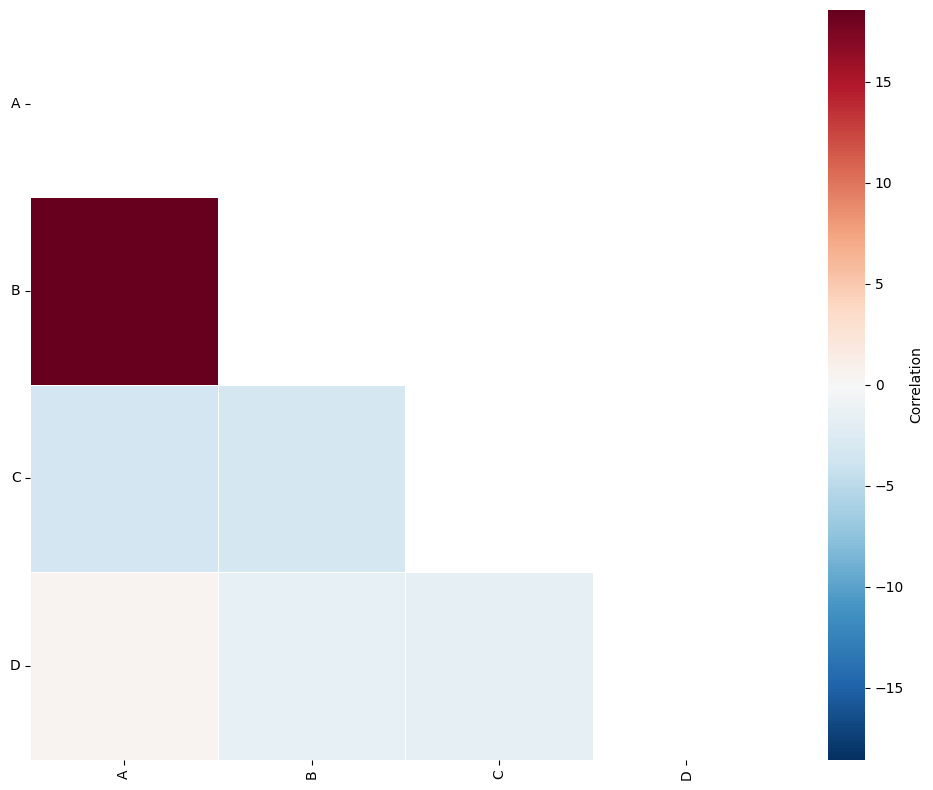

In [13]:
SES,A,labels_categories = ms.region_based.quadrat_correlation_matrix(example_domain,
                                                                     label_name='Celltype',
                                                                     region_method='quadrats',
                                                                     region_kwargs=dict(side_length=50),
                                                                     visualise_output=True)

Criticially, we see an amplification of the local correlation between A and B cells with the smaller regions, and we lose the longer range correlation between the noisy D type points.

### Exploring further

1. A key part of the cross-PCF analysis, and indeed any spatial analysis, is the shape of the domain (i.e., the boundary). Load in any example domain, and calculate the cross-PCF between two cell types. Now [try manually changing the domain boundary](https://docs.muspan.co.uk/latest/muspan.domain.html#muspan.domain.estimate_boundary) to make it much bigger (for instance, twice as big in both the $x$ and $y$ directions). What happens when you recalculate the same cross-PCF on the same cell types? Can you explain why?

2. The boundary of a cross-PCF is extremely important, as we've just seen. Try [following the tutorial on using shapes as calculation boundaries for cross-PCFs](https://docs.muspan.co.uk/latest/_collections/spatial_analysis_methods/Spatial%20stats%20-%202%20-%20boundary%20corrections.html).

3. Load in the dataset `Synthetic-Points-Exclusion` and calculate the cross-PCF betwen cell types A and B. You should see strong spatial correlation, as the points are all in the same part of the domain. Try [following the instructions in the tutorial on converting points to shapes](https://docs.muspan.co.uk/latest/_collections/working_with_objects/WWO%20-%203%20-%20points%20to%20shape%203.html) to make the convex hull around all points of type D. Can you use this shape as the boundary for the cross-PCF analysis (between cell types A and B)? What do you see?

4. There are many other approaches for comparing pairs of point populations, many of which can be found in [the documentation for MuSpAn's spatial statistics](https://docs.muspan.co.uk/latest/muspan.spatial_statistics.html). Try out some others - you may want to consider the K-function, the J-function, and the average nearest neighbour index (for example).

5. The TCM provides one way of showing local correlation between cells of different types, but there are many other methods. Try following the tutorial on Getis-Ord hotspot analysis to identify whether there is a correlation between cells of types D and A in the `Synthetic-Points-Architecture` dataset.

6. Try loading in the `Xenium-Healthy-Colon` dataset. Can you use Getis-Ord* to identify statistically signficant clustering of cells pointing in the same direction? 
(Hint - Start by isolating the cell boundaries, and then calculate the Principal Angle of each one, assigning it as a label. Then use this to calculate and visualise the Local Getis-Ord* across the region of interest.)

7. Using the `Mouse-Colon-Carcinoma`, using the QCM with regions sizes at 50 and 150µm to idenify cell type pairs that exhibt exclusion or co-localistion. Then compute the PCF in this region for the the identified pairs up to 300µm. Do these resultant outputs agree? What happens if we choose a different annulus width for computing the PCF? 